# Capstone Project: Environmental and Socioeconomic Factors Impacting Cardiovascular Disease (CVD) in California
This project investigates the relationship between environmental exposures, social vulnerabilities, and cardiovascular disease (CVD) prevalence across communities in California. Using the CalEnviroScreen 4.0 dataset, which compiles detailed metrics at the census-tract level, the analysis explores how factors such as air quality (e.g., PM2.5, ozone), pollution exposure (e.g., diesel particulate matter, toxic releases), and demographic pressures (e.g., poverty, housing burden, linguistic isolation) contribute to disparities in cardiovascular health outcomes.

## Data Source: 
Link https://oehha.ca.gov/calenviroscreen/report/calenviroscreen-40
The primary dataset for this analysis is the CalEnviroScreen 4.0 dataset provided by the California Office of Environmental Health Hazard Assessment (OEHHA), which includes over 80 variables for 8,000+ census tracts in California. The dataset contains environmental indicators (e.g., ozone, PM2.5, diesel particulate matter), population health data (e.g., asthma, low birth weight, cardiovascular disease), and demographic factors (e.g., poverty rate, educational attainment, housing burden)

## Goals
- Understand the spatial and statistical patterns of cardiovascular disease across the state
- Identify which environmental and socioeconomic factors are most strongly correlated with CVD rates
- Build a baseline regression model to predict CVD risk based on these features
- Inform public health and environmental justice efforts by identifying high-risk communitie

### 1. Project Setup

#### Import Libraries

In [567]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score, KFold

#### Load Dataset


In [569]:

# Define file path and target sheet name
file_path = "../data/calenviroscreen40resultsdatadictionary_F_2021.xlsx"
sheet_name = "CES4.0FINAL_results"

# Check if file exists
if not os.path.exists(file_path):
    raise FileNotFoundError(f"File not found: '{file_path}'. Please ensure the file is in the 'data/' directory.")

try:
    # Try reading the Excel file
    xls = pd.ExcelFile(file_path)
    
    # Check if the sheet exists
    if sheet_name not in xls.sheet_names:
        raise ValueError(f"Sheet '{sheet_name}' not found in '{file_path}'. Available sheets: {xls.sheet_names}")
    
    # Load the sheet into a DataFrame
    df = pd.read_excel(xls, sheet_name=sheet_name)
    print("Dataset loaded successfully!")

except Exception as e:
    print(f"Error loading data: {e}")

Dataset loaded successfully!


#### Overview of dataframe

In [571]:
print(f"Dataset Shape: {df.shape}")
df.info()
df.head(3)


Dataset Shape: (8035, 58)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8035 entries, 0 to 8034
Data columns (total 58 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Census Tract                 8035 non-null   int64  
 1   Total Population             8035 non-null   int64  
 2   California County            8035 non-null   object 
 3   ZIP                          8035 non-null   int64  
 4   Approximate Location         8035 non-null   object 
 5   Longitude                    8035 non-null   float64
 6   Latitude                     8035 non-null   float64
 7   CES 4.0 Score                7932 non-null   float64
 8   CES 4.0 Percentile           7932 non-null   float64
 9   CES 4.0 Percentile Range     7932 non-null   object 
 10  Ozone                        8035 non-null   float64
 11  Ozone Pctl                   8035 non-null   float64
 12  PM2.5                        8035 non-null   float

,Census Tract,Total Population,California County,ZIP,Approximate Location,Longitude,Latitude,CES 4.0 Score,CES 4.0 Percentile,CES 4.0 Percentile Range,...,Linguistic Isolation Pctl,Poverty,Poverty Pctl,Unemployment,Unemployment Pctl,Housing Burden,Housing Burden Pctl,Pop. Char.,Pop. Char. Score,Pop. Char. Pctl
0,6019001100,2780,Fresno,93706,Fresno,-119.781696,36.709695,93.183570,100.000000,95-100% (highest scores),...,79.374746,76.0,98.919598,12.8,93.831338,30.3,91.039290,93.155109,9.663213,99.722642
1,6077000700,4680,San Joaquin,95206,Stockton,-121.287873,37.943173,86.653790,99.987393,95-100% (highest scores),...,95.533902,73.2,98.391960,19.8,99.206143,31.2,92.281369,93.165408,9.664281,99.735250
2,6037204920,2751,Los Angeles,90023,Los Angeles,-118.197497,34.017500,82.393909,99.974786,95-100% (highest scores),...,81.553661,62.6,93.391960,6.4,61.530453,20.3,63.967047,83.751814,8.687785,95.789208


### 2. Data Preparation

#### Check for missing values

In [574]:
# Check total missing values per column
missing = df.isnull().sum()
missing[missing > 0].sort_values(ascending=False)

Unemployment Pctl              335
Unemployment                   335
Linguistic Isolation Pctl      320
Linguistic Isolation           320
Low Birth Weight               227
Low Birth Weight Pctl          227
Housing Burden Pctl            145
Housing Burden                 145
CES 4.0 Score                  103
CES 4.0 Percentile             103
Pop. Char. Score               103
Pop. Char.                     103
Education Pctl                 103
Education                      103
Pop. Char. Pctl                103
CES 4.0 Percentile Range       103
Lead Pctl                       96
Lead                            96
Poverty                         75
Poverty Pctl                    75
Traffic Pctl                    35
Traffic                         35
Drinking Water Pctl             28
Drinking Water                  28
Cardiovascular Disease          11
Asthma Pctl                     11
Asthma                          11
Cardiovascular Disease Pctl     11
dtype: int64

In [575]:
# Drop rows with any missing or null values in the selected columns
df_cleaned = df.dropna()

print(f"Cleaned dataset shape: {df_cleaned.shape}")


Cleaned dataset shape: (7355, 58)


In [576]:
# Count duplicates
duplicate_count = df_cleaned.duplicated().sum()
print(f"Duplicate rows: {duplicate_count}")

# Remove duplicates
df_cleaned = df_cleaned.drop_duplicates()

Duplicate rows: 0


In [577]:
# Define relevant variables
environmental_factors = [
    "Ozone", "PM2.5", "Diesel PM", "Drinking Water", "Lead", "Pesticides",
    "Tox. Release", "Traffic", "Cleanup Sites", "Groundwater Threats",
    "Haz. Waste", "Imp. Water Bodies", "Solid Waste"
]

social_factors = [
    "Education", "Linguistic Isolation", "Poverty", "Unemployment", "Housing Burden"
]

target_variable = "Cardiovascular Disease"

# Combine into final list of columns of interest
selected_columns = environmental_factors + social_factors + [target_variable]

# Subset the dataset
df_selected = df_cleaned[selected_columns].copy()

In [578]:
# Display descriptive statistics for all selected variables
summary_stats = df_selected.describe().T
summary_stats = summary_stats[["count", "mean", "std", "min", "25%", "50%", "75%", "max"]]
summary_stats

,count,mean,std,min,25%,50%,75%,max
Ozone,7355.0,0.048655,0.010423,0.026554,0.041926,0.047165,0.056800,0.073132
PM2.5,7355.0,10.241618,2.109606,3.115233,8.606971,10.335114,11.953324,16.394748
Diesel PM,7355.0,0.227852,0.258413,0.000214,0.072389,0.150770,0.292595,4.751602
Drinking Water,7355.0,479.928371,218.645377,32.568922,305.292089,433.100961,685.634214,1179.478774
Lead,7355.0,49.557652,23.127495,0.000000,31.335271,49.558321,67.465570,99.352332
Pesticides,7355.0,273.021943,2391.260520,0.000000,0.000000,0.000000,0.153506,80811.089450
Tox. Release,7355.0,1627.293615,3671.554116,0.000000,122.445833,484.488345,1673.394786,96985.629960
Traffic,7355.0,1131.298055,995.684541,20.748148,571.318021,887.573098,1397.213090,45752.000000
Cleanup Sites,7355.0,8.545942,16.166135,0.000000,0.000000,2.000000,10.700000,300.950000
Groundwater Threats,7355.0,16.476621,32.769498,0.000000,0.300000,6.000000,18.750000,673.750000


In [579]:
# Save cleaned subset for modeling/EDA use
output_path = "../data/cvd_cleaned_environmental_social.csv"
df_selected.to_csv(output_path, index=False)
print(f"Cleaned dataset saved to: {output_path}")

Cleaned dataset saved to: ../data/cvd_cleaned_environmental_social.csv


In [580]:
# Print initial rows of cleaned data
df_selected.head(5)

,Ozone,PM2.5,Diesel PM,Drinking Water,Lead,Pesticides,Tox. Release,Traffic,Cleanup Sites,Groundwater Threats,Haz. Waste,Imp. Water Bodies,Solid Waste,Education,Linguistic Isolation,Poverty,Unemployment,Housing Burden,Cardiovascular Disease
0,0.060311,13.906348,1.122712,733.946935,89.600854,1.001925,4859.094604,1037.095744,70.50,54.25,3.10,0,6.00,44.5,16.0,76.0,12.8,30.3,21.47
1,0.045884,11.884085,0.538105,389.846569,77.302272,63.132574,519.628001,856.395935,61.90,78.60,1.27,13,9.25,46.4,29.7,73.2,19.8,31.2,20.26
2,0.047920,12.251640,0.780833,787.940335,92.563660,0.000000,3682.693278,2522.622269,38.75,20.50,11.62,7,4.85,52.2,17.1,62.6,6.4,20.3,20.87
3,0.060311,13.520939,0.173815,733.946935,68.385084,44.574874,1630.342707,690.502159,16.50,9.50,2.36,0,5.75,41.4,15.7,65.7,15.7,35.4,22.68
4,0.060311,13.818959,1.389658,733.946935,75.414535,16.625496,1975.207988,909.650882,10.50,28.25,0.35,0,0.00,43.6,20.0,72.7,13.7,32.7,22.64


### 3. Exploratory Data Analysis (EDA) 

To explore the cleaned CalEnviroScreen dataset for patterns, distributions, and relationships between environmental and social factors and cardiovascular disease (CVD) rates, identifying trends and outliers before modeling

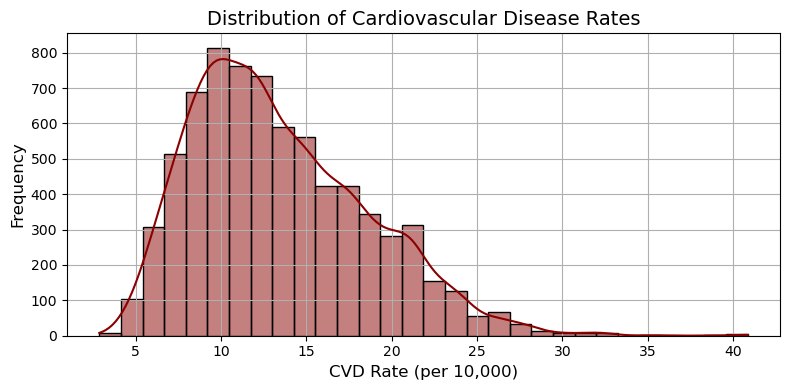

In [583]:
#Distribution of Variable

plt.figure(figsize=(8, 4))
sns.histplot(df_selected['Cardiovascular Disease'], bins=30, kde=True, color='darkred')
plt.title("Distribution of Cardiovascular Disease Rates", fontsize=14)
plt.xlabel("CVD Rate (per 10,000)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

The distribution is **right-skewed**, with most census tracts between 9.5–16.8 and some outliers up to 40.85. This indicates variability in CVD rates across California, informing targeted public health interventions.


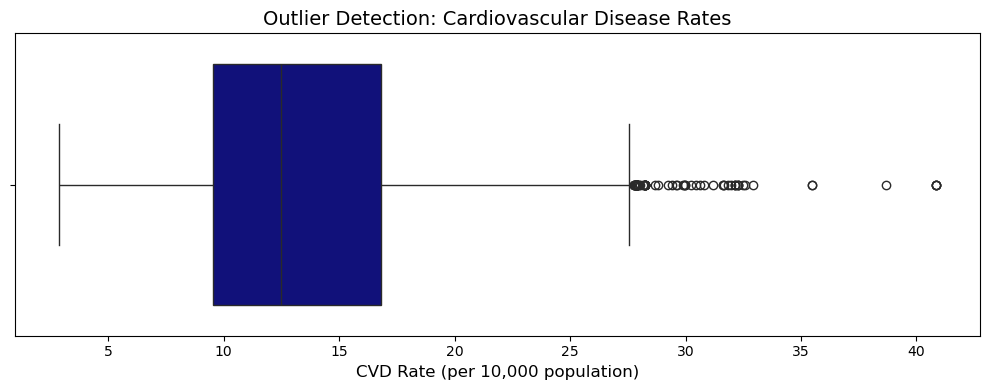

Number of outliers detected: 70
Outlier lower bound: -1.41, upper bound: 27.74


In [585]:
# Outlier Detection

# Boxplot for outlier detection
plt.figure(figsize=(10, 4))
sns.boxplot(x=df_selected['Cardiovascular Disease'], color='darkblue')
plt.title('Outlier Detection: Cardiovascular Disease Rates', fontsize=14)
plt.xlabel('CVD Rate (per 10,000 population)', fontsize=12)
plt.tight_layout()
plt.show()

# Calculate IQR for quantitative outlier detection
Q1 = df_selected['Cardiovascular Disease'].quantile(0.25)
Q3 = df_selected['Cardiovascular Disease'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = df_selected[(df_selected['Cardiovascular Disease'] < lower_bound) | 
                       (df_selected['Cardiovascular Disease'] > upper_bound)]

print(f"Number of outliers detected: {outliers.shape[0]}")
print(f"Outlier lower bound: {lower_bound:.2f}, upper bound: {upper_bound:.2f}")

In [586]:
# Remove rows where CVD rate is negative
df_selected = df_selected[df_selected['Cardiovascular Disease'] >= 0]

print(f"Number of rows after removing negative CVD values: {df_selected.shape[0]}")

Number of rows after removing negative CVD values: 7355


In [587]:
# Remove rows where CVD rate is above upper bound
df_selected = df_selected[df_selected['Cardiovascular Disease'] <= upper_bound]

print(f"Number of rows after removing upper bound outliers: {df_selected.shape[0]}")


Number of rows after removing upper bound outliers: 7285


In [588]:
# Display descriptive statistics for all selected variables
summary_stats = df_selected.describe().T
summary_stats = summary_stats[["count", "mean", "std", "min", "25%", "50%", "75%", "max"]]
summary_stats

,count,mean,std,min,25%,50%,75%,max
Ozone,7285.0,0.048592,0.010418,0.026554,0.041926,0.047165,0.056800,0.073132
PM2.5,7285.0,10.244064,2.107579,3.115233,8.608990,10.336043,11.950614,16.394748
Diesel PM,7285.0,0.228222,0.258853,0.000214,0.072669,0.151161,0.292665,4.751602
Drinking Water,7285.0,479.820680,218.916920,32.568922,304.146245,432.868985,685.634214,1179.478774
Lead,7285.0,49.473831,23.128266,0.000000,31.208087,49.496623,67.429473,99.352332
Pesticides,7285.0,274.760616,2402.459794,0.000000,0.000000,0.000000,0.151168,80811.089450
Tox. Release,7285.0,1610.881304,3569.822477,0.000000,124.387446,486.087657,1665.137716,96985.629960
Traffic,7285.0,1131.248993,995.350756,20.920085,573.245603,888.141728,1397.421255,45752.000000
Cleanup Sites,7285.0,8.569067,16.198844,0.000000,0.000000,2.050000,10.700000,300.950000
Groundwater Threats,7285.0,16.482800,32.829552,0.000000,0.300000,6.000000,18.750000,673.750000


In [589]:
# List of numeric columns to scale (excluding target variable)
numeric_cols = df_selected.select_dtypes(include=['float64', 'int64']).columns.tolist()
if 'Cardiovascular Disease' in numeric_cols:
    numeric_cols.remove('Cardiovascular Disease')

# Initialize scaler
scaler = StandardScaler()

# Fit and transform the numeric columns
df_selected[numeric_cols] = scaler.fit_transform(df_selected[numeric_cols])

# Display first few rows to verify
df_selected.head()

,Ozone,PM2.5,Diesel PM,Drinking Water,Lead,Pesticides,Tox. Release,Traffic,Cleanup Sites,Groundwater Threats,Haz. Waste,Imp. Water Bodies,Solid Waste,Education,Linguistic Isolation,Poverty,Unemployment,Housing Burden,Cardiovascular Disease
0,1.124962,1.737792,3.455834,1.160914,1.735097,-0.113957,0.909971,-0.094600,3.823432,1.150481,1.690486,-0.771731,0.979561,1.827106,0.647920,2.475796,1.813050,1.452344,21.47
1,-0.260041,0.778207,1.197225,-0.411025,1.203305,-0.088094,-0.305709,-0.276156,3.292494,1.892242,0.421225,1.908877,1.777824,1.956202,2.094476,2.321388,3.727803,1.562810,20.26
2,-0.064577,0.952616,2.134994,1.407570,1.863209,-0.114374,0.580408,1.397968,1.863281,0.122374,7.599833,0.671673,0.697099,2.350283,0.764067,1.736843,0.062420,0.224951,20.87
3,1.124962,1.554912,-0.210199,1.160914,0.817725,-0.095819,0.005452,-0.442836,0.489632,-0.212713,1.177233,-0.771731,0.918156,1.616476,0.616244,1.907795,2.606305,2.078315,22.68
4,1.124962,1.696326,4.487172,1.160914,1.121679,-0.107454,0.102064,-0.222648,0.119210,0.358458,-0.216873,-0.771731,-0.494155,1.765955,1.070272,2.293815,2.059233,1.746919,22.64


#### Correlation plot

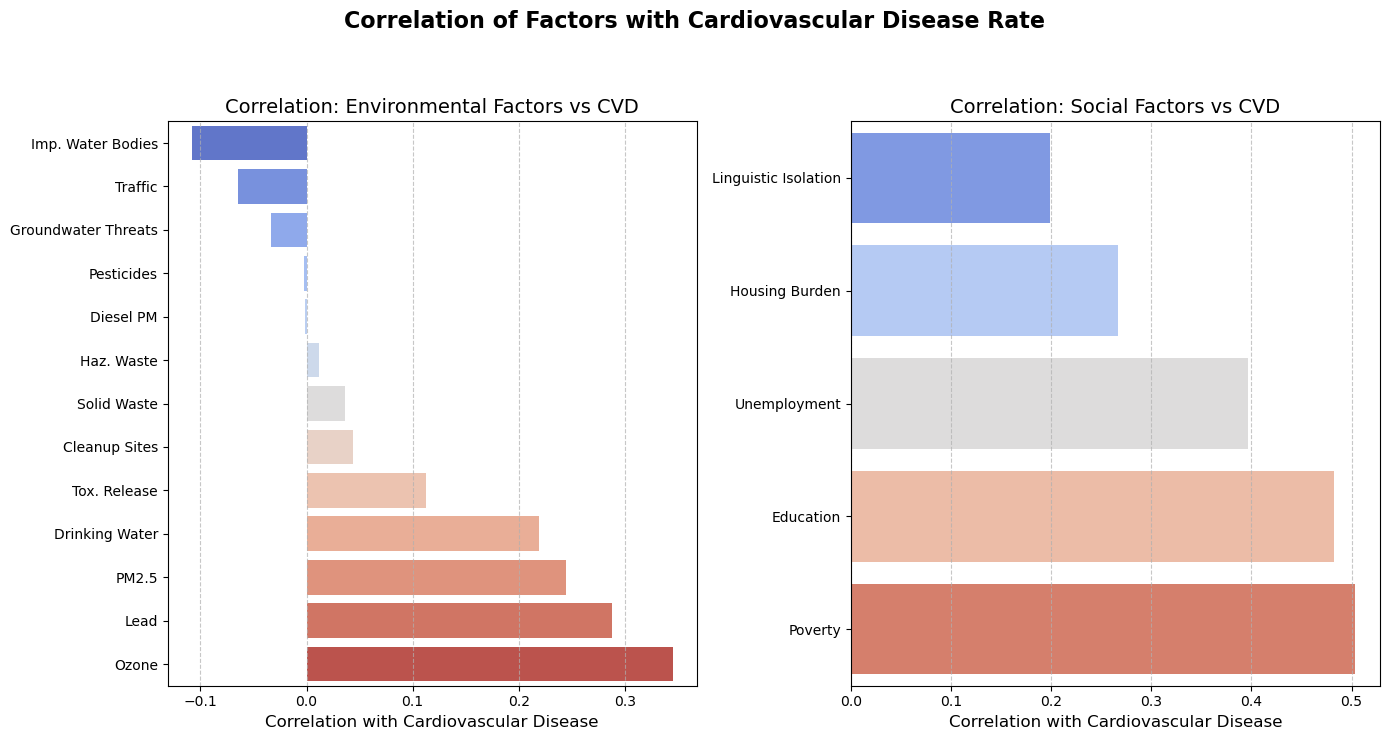

In [591]:
# Factor groups
environmental_factors = [
    "Ozone", "PM2.5", "Diesel PM", "Drinking Water", "Lead", "Pesticides",
    "Tox. Release", "Traffic", "Cleanup Sites", "Groundwater Threats",
    "Haz. Waste", "Imp. Water Bodies", "Solid Waste"
]

social_factors = [
    "Education", "Linguistic Isolation", "Poverty", "Unemployment", "Housing Burden"
]

# Calculate correlations with target variable 'Cardiovascular Disease'
env_corr = df_selected[environmental_factors + ['Cardiovascular Disease']].corr()['Cardiovascular Disease'].drop('Cardiovascular Disease')
soc_corr = df_selected[social_factors + ['Cardiovascular Disease']].corr()['Cardiovascular Disease'].drop('Cardiovascular Disease')

# Plotting function to keep plots consistent and readable
def plot_correlation_bar(corr_series, title, ax):
    corr_df = corr_series.reset_index()
    corr_df.columns = ['Factor', 'Correlation with CVD']
    corr_df = corr_df.sort_values(by='Correlation with CVD', ascending=True)
    sns.barplot(
        data=corr_df,
        x='Correlation with CVD',
        y='Factor',
        hue='Factor',
        dodge=False,
        palette='coolwarm',
        legend=False,
        ax=ax
    )
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Correlation with Cardiovascular Disease', fontsize=12)
    ax.set_ylabel('')
    ax.grid(axis='x', linestyle='--', alpha=0.7)

# Create subplots for environmental and social correlations
fig, axes = plt.subplots(1, 2, figsize=(14, 7), tight_layout=True)

plot_correlation_bar(env_corr, 'Correlation: Environmental Factors vs CVD', axes[0])
plot_correlation_bar(soc_corr, 'Correlation: Social Factors vs CVD', axes[1])

plt.suptitle('Correlation of Factors with Cardiovascular Disease Rate', fontsize=16, weight='bold', y=1.05)
plt.show()


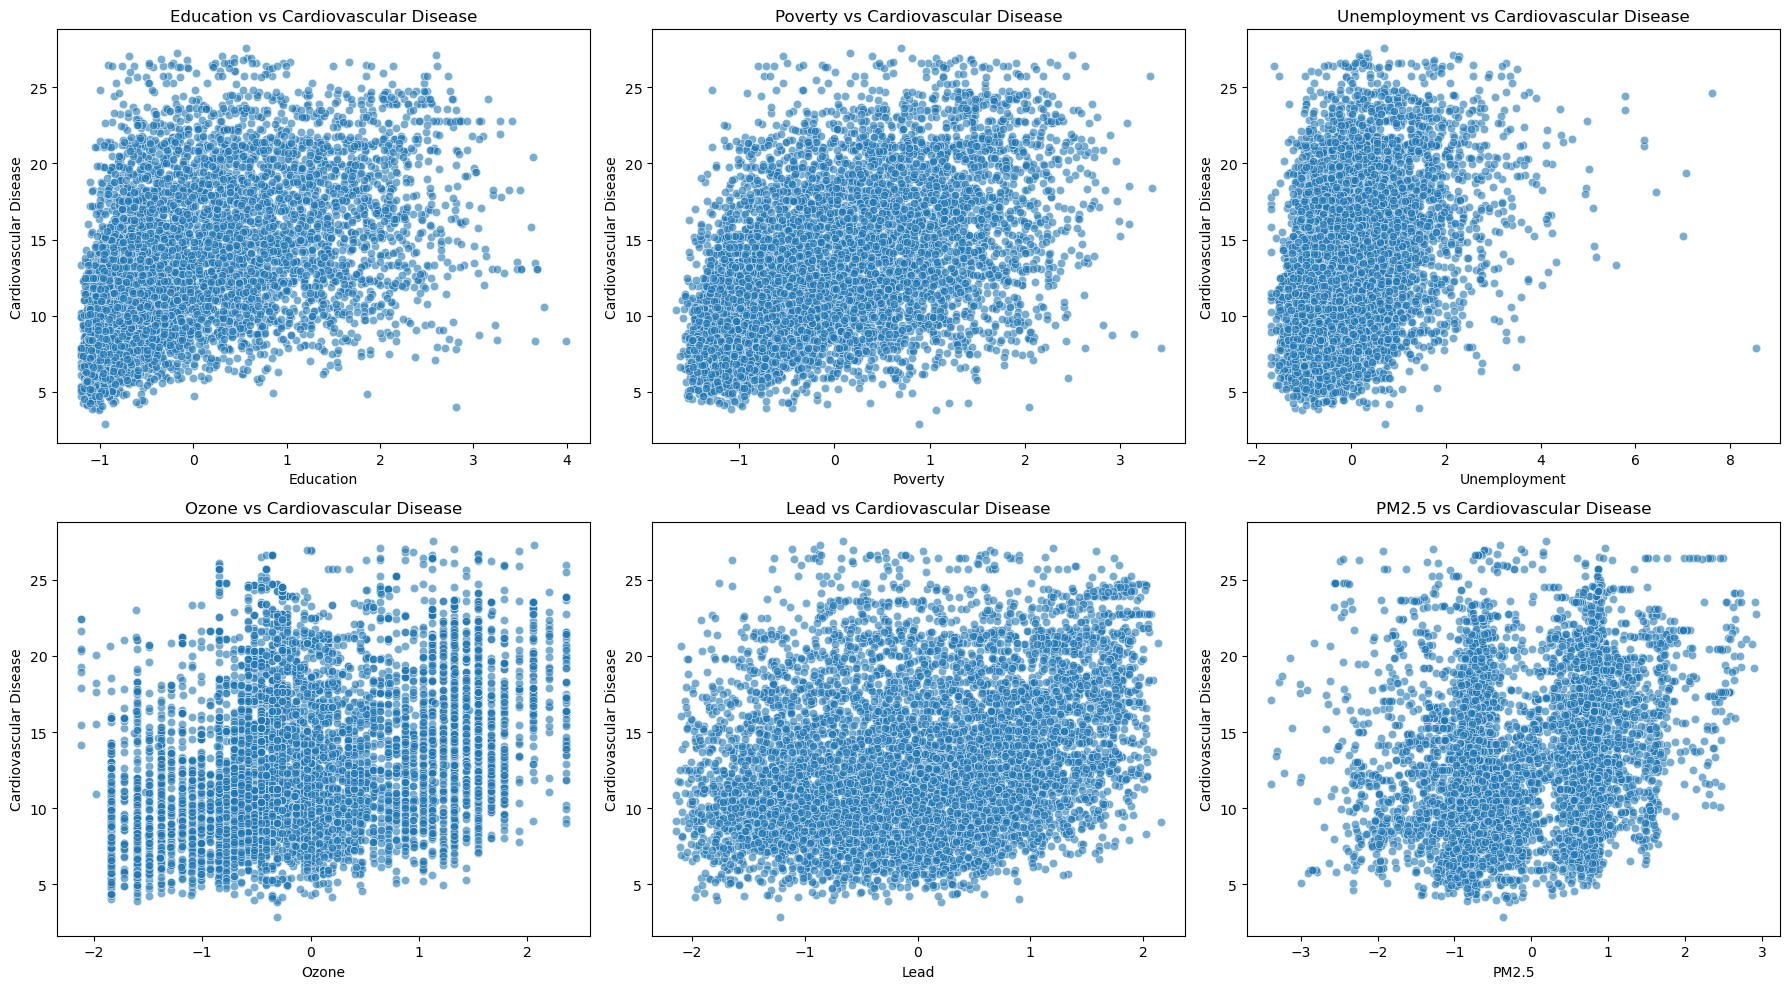

In [592]:
#Scatter plots: Top features vs CVD
top_features = ['Education', 'Poverty', 'Unemployment', 'Ozone','Lead','PM2.5']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for ax, feature in zip(axes.flatten(), top_features):
    sns.scatterplot(
        x=df_selected[feature],
        y=df_selected[target_variable],
        ax=ax,
        alpha=0.6
    )
    ax.set_title(f"{feature} vs Cardiovascular Disease")
    ax.set_xlabel(feature)
    ax.set_ylabel('Cardiovascular Disease')

plt.tight_layout()
plt.show()

### Key Insights:

1. **Social factors show stronger correlations with Cardiovascular Disease (CVD) rates than environmental factors:**
- **Poverty (0.503)** and **Education (0.482)** have the highest positive correlations with CVD rates, indicating that **socioeconomic stress and potentially lower education levels may be significant drivers of higher CVD rates** in the dataset.
- **Unemployment (0.396)** also shows a notable positive correlation, reinforcing the impact of economic hardship on cardiovascular health.

2. **Environmental factors with the highest positive correlations:**
- **Ozone (0.345)**, **Lead (0.288)**, **PM2.5 (0.245)**, and **Drinking Water (0.219)** are positively correlated with CVD rates.
- This suggests that **air quality and water factors may be contributing environmental risks for cardiovascular health**, consistent with public health studies linking air pollution and heavy metals exposure to CVD.

3. **Weak or negative correlations:**
- Some environmental factors, such as **Impacted Water Bodies (-0.108)** and **Traffic (-0.064)**, exhibit weak negative correlations with CVD rates.
- These require further exploration to determine if they reflect **regional or data-specific patterns** or if they are influenced by confounding factors.


### Summary:
- **Socioeconomic stress indicators are the strongest signals associated with CVD in this dataset.**
- **Environmental factors, especially air pollutants, are secondary but notable contributors.**


###Feature Engineering (PCA)

In [595]:
# Select top correlated features
top_features = ['Poverty', 'Education', 'Unemployment', 'Ozone', 'Lead', 'PM2.5', 'Drinking Water', 'Cardiovascular Disease']


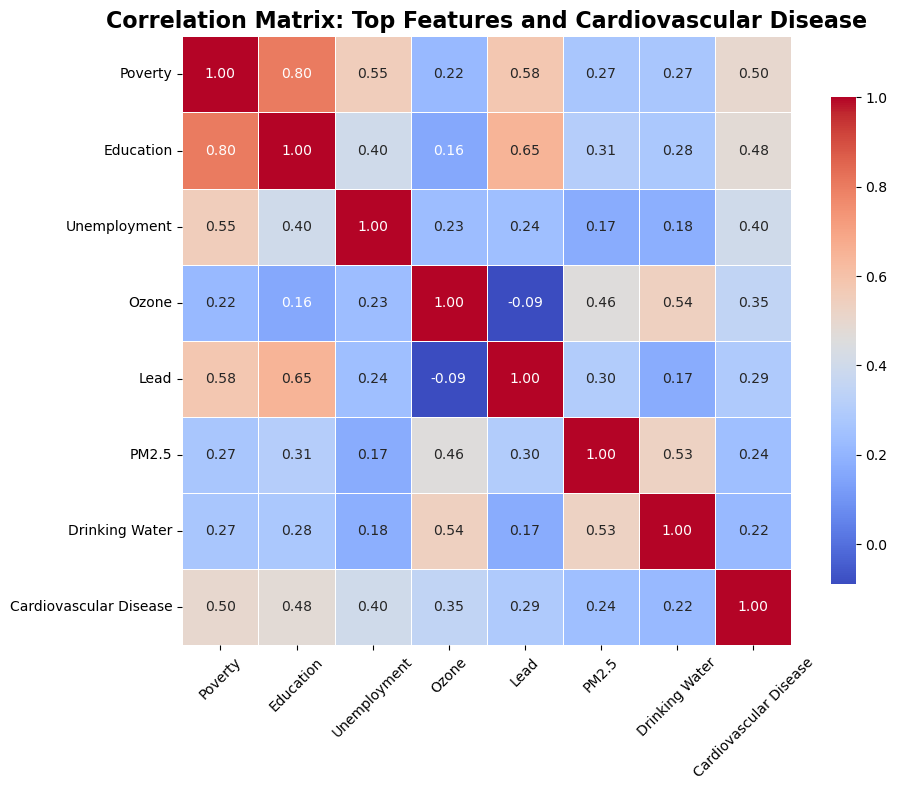

In [596]:
# Compute correlation matrix for top features
corr_matrix = df_selected[top_features].corr().round(2)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    linewidths=0.5,
    square=True,
    cbar_kws={'shrink': 0.8}
)
plt.title('Correlation Matrix: Top Features and Cardiovascular Disease', fontsize=16, weight='bold')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

#### High Intercorrelations Detected

- **Poverty and Education (0.80):** High correlation, suggesting potential multicollinearity.

In [598]:
from sklearn.decomposition import PCA
# Features to analyze
features_pca = ['Poverty', 'Education', 'Lead']

# Extract and scale
X_pca = df_selected[features_pca].copy()
scaler_pca = StandardScaler()
X_scaled = scaler_pca.fit_transform(X_pca)

# Perform PCA
pca = PCA()
pca.fit(X_scaled)

# Explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Display explained variance table
explained_variance_table = pd.DataFrame({
    'Principal Component': [f'PC{i+1}' for i in range(len(explained_variance))],
    'Explained Variance Ratio': explained_variance,
    'Cumulative Variance': cumulative_variance
})

display(explained_variance_table.style.format({
    'Explained Variance Ratio': "{:.3f}",
    'Cumulative Variance': "{:.3f}"
}).background_gradient(cmap='Blues'))

,Principal Component,Explained Variance Ratio,Cumulative Variance
0,PC1,0.785,0.785
1,PC2,0.149,0.934
2,PC3,0.066,1.000


#### Feature Selection to Reduce Multicollinearity

- **Drop the feature `Lead`** to reduce multicollinearity in the dataset.
- **Retain `Poverty` and `Education`** for interpretability and strong predictive power.
- Rationale:
  - Poverty and Education are **stronger predictors of Cardiovascular Disease (CVD)**.
  - Dropping Lead still retains **93.4% of the variance** in the data with the remaining components.

In [600]:
# Dropping Lead feature to reduce multicollinearity
df_selected = df_selected.drop(columns=['Lead'])


### 4. Linear Regression

#### Model Selection and Evaluation Metrics

- Since the target variable **Cardiovascular Disease rate** is continuous, a **regression model (linear regression)** is appropriate.

- **Primary metric:** Root Mean Squared Error (**RMSE**)

  - Penalizes larger errors more heavily due to squaring.
  - Provides error measure in the same units as the target variable (CVD rate), aiding interpretability.
  - Commonly used in regression tasks for model comparison.

- **Secondary metric:** Coefficient of Determination (**R²**)

  - Indicates the proportion of variance in the target explained by the model.
  - Helps assess goodness of fit, with values closer to 1 indicating better fit.


In [603]:
# Split data into train and test sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train linear regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict on test data
y_pred = lr.predict(X_test)

# Evaluate model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")

RMSE: 4.008
R²: 0.353


Baseline RMSE of ~4.0 and R² of ~0.35, which is a decent start but leaves room for improvement

**Next Steps**
- Explore the interaction terms and also consider polynominal features (eg. square)
- Use Ridge to reduce overfitting and improve generalization
- Use GridSearchCV to optimize model hyperparameters. 

In [605]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge

# Pipeline with scaling, polynomial features (degree=3, include interaction terms), and Ridge regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=3, interaction_only=False, include_bias=False)),
    ('ridge', Ridge())
])

# Grid of alpha values to search
param_grid = {
    'ridge__alpha': [0.01, 0.1, 1, 10, 100]
}

# GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Best alpha: {grid_search.best_params_['ridge__alpha']}")
print(f"Best CV RMSE: {-grid_search.best_score_:.3f}")

# Evaluate on test set
y_pred = grid_search.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
r2_test = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse_test:.3f}")
print(f"Test R²: {r2_test:.3f}")

# Extract feature names after polynomial expansion
poly = grid_search.best_estimator_.named_steps['poly']
feature_names = poly.get_feature_names_out(features)

# Extract coefficients from Ridge model
ridge = grid_search.best_estimator_.named_steps['ridge']
coefficients = ridge.coef_

# Combine feature names and coefficients into DataFrame for interpretation
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sort by absolute coefficient magnitude to identify most important features
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df_sorted = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

# Show top features (e.g., top 10)
print("\nTop polynomial features and interaction terms by coefficient magnitude:")
print(coef_df_sorted.head(10))

Best alpha: 100
Best CV RMSE: 3.668
Test RMSE: 3.695
Test R²: 0.450

Top polynomial features and interaction terms by coefficient magnitude:
                          Feature  Coefficient  Abs_Coefficient
1                       Education     1.332963         1.332963
14                    Education^2    -1.079184         1.079184
2                    Unemployment     1.051150         1.051150
3                           Ozone     0.967037         0.967037
0                         Poverty     0.953712         0.953712
30                     Lead PM2.5     0.897939         0.897939
32                        PM2.5^2     0.642857         0.642857
104              Ozone Lead PM2.5    -0.640941         0.640941
12                  Poverty PM2.5    -0.578515         0.578515
61   Poverty PM2.5 Drinking Water    -0.515278         0.515278


<b> Insights </b>
- Increasing the polynomial degree to 3 improves predictive performance (R² = 0.45)
- Education remains the most influential factor with a strong main and nonlinear effect.
- Interactions involving Lead, PM2.5, and Ozone continue to be important, highlighting the combined impact of environmental pollutants.
- Complex interactions like three-way terms suggest the disease risk depends on multifactorial synergy between social and environmental factors.
- Quadratic terms for key variables indicate nonlinear relationships with cardiovascular disease rates.

<b> Next Step </b>
- Cross-validation: Use repeated k-fold or nested CV for more robust performance estimates.
- Visualization: Plot residuals, feature importances, and interaction effects for richer insights.



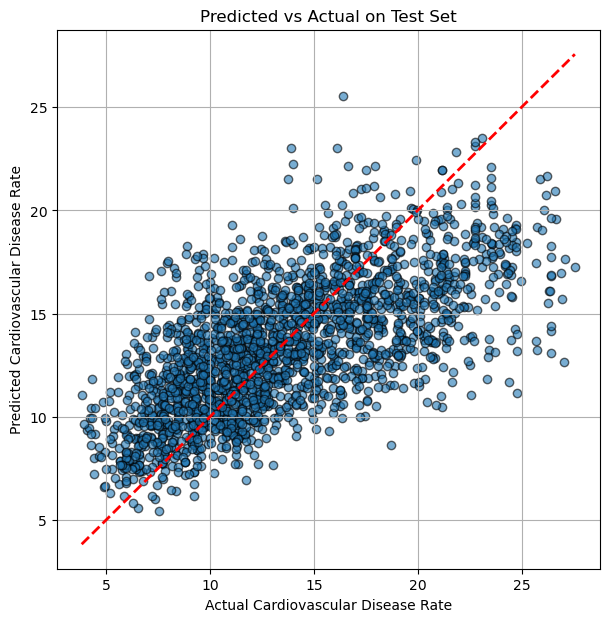

5-Fold CV RMSE: 3.650
5-Fold CV R²: 0.440


In [607]:
from sklearn.model_selection import cross_val_predict, KFold

# Use the best estimator from your GridSearchCV (degree 3 poly + Ridge with best alpha)
best_model = grid_search.best_estimator_

# Predict on test set
y_pred_test = best_model.predict(X_test)

# Plot predicted vs actual for test set
plt.figure(figsize=(7, 7))
plt.scatter(y_test, y_pred_test, alpha=0.6, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Cardiovascular Disease Rate')
plt.ylabel('Predicted Cardiovascular Disease Rate')
plt.title('Predicted vs Actual on Test Set')
plt.grid(True)
plt.show()

# 5-fold Cross-Validation Predictions
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_pred = cross_val_predict(best_model, X, y, cv=kf, n_jobs=-1)

# Compute CV RMSE and R2
cv_rmse = np.sqrt(mean_squared_error(y, cv_pred))
cv_r2 = r2_score(y, cv_pred)

print(f"5-Fold CV RMSE: {cv_rmse:.3f}")
print(f"5-Fold CV R²: {cv_r2:.3f}")


#### Model Performance: 5-Fold Cross-Validation

- **5-Fold CV RMSE:** **3.650**  
  This means that, on average, the model’s predicted cardiovascular disease rate differs from the actual rate by approximately **3.65 units** across folds.

- **5-Fold CV R²:** **0.440**  
  The model explains **44.0% of the variance** in cardiovascular disease rates, indicating a moderate fit and capturing important patterns in the data.

---

#### Interpretation

The 5-fold cross-validation results indicate:

- The polynomial Ridge regression model **generalizes well** to unseen data without overfitting.  
- The model captures **nonlinear and interaction effects** among social and environmental factors.  
- This performance establishes a **robust baseline** for further refinement with advanced modeling or feature engineering.

While there is room for improvement, this model provides a **strong foundation** for understanding and predicting cardiovascular disease rates across communities using environmental and social variables.
